## Table of Contents

- [1. Data Extraction & Preprocessing](#1)
    - [1.1 Import Libraries & Data Source](#1_1)
    - [1.2 Missing Data](#1_2)
    - [1.3 Data Types & Feature Creation](#1_3)
- [2. Model Training and Analysis](#2)
    - [2.1 Data Preparation](#2_1)
    - [2.2 Model Training &  Evaluation](#2_2)
        - [2.2.1 Dummy Model](#2_2_1)
        - [2.2.2 Logistic Regressor](#2_2_2)
        - [2.2.3 Boosted Classifier - CatBoost](#2_2_3)
        - [2.2.4 Multilayer Neural Network](#2_2_4)
- [3. Parameter Hypertuning](#3)
- [Conclusion](#end)

## 1. Data Extraction & Preprocessing <a class="anchor" id="1"></a>

### 1.1 Import libraries and data sources <a class="anchor" id="1_1"></a>

In [4]:
# import libraries and data sources
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [5]:
try:
    df_contract = pd.read_csv('../datasets/contract.csv')
    df_internet = pd.read_csv('../datasets/internet.csv')
    df_personal = pd.read_csv('../datasets/personal.csv')
    df_phone = pd.read_csv('../datasets/phone.csv')
    dfs = [df_contract,df_internet,df_personal,df_phone]
    for df in dfs:
        display(df.sample(3),df.shape)
except:
    print('Data not found')


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2415,9898-KZQDZ,2016-06-01,2019-10-01 00:00:00,Month-to-month,Yes,Credit card (automatic),94.55,3640.45
2617,4588-YBNIB,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,19.60,19.6
6992,0218-QNVAS,2014-03-01,No,One year,No,Bank transfer (automatic),100.55,7113.75


(7043, 8)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4244,3563-SVYLG,DSL,Yes,Yes,Yes,Yes,No,No
150,8017-UVSZU,DSL,No,Yes,No,No,No,No
3544,3428-XZMAZ,Fiber optic,No,No,No,No,No,No


(5517, 8)

,customerID,gender,SeniorCitizen,Partner,Dependents
6954,9364-YKUVW,Male,0,No,No
3279,6064-PUPMC,Male,0,Yes,Yes
3086,3853-LYGAM,Male,0,No,No


(7043, 5)

,customerID,MultipleLines
4221,5458-CQJTA,No
6133,3090-HAWSU,Yes
2935,8173-RXAYP,No


(6361, 2)

In [6]:
# merge all dataframes
dfs = [df_internet,df_personal,df_phone]
df = df_contract
for d in dfs:
    df = pd.merge(df,d,on='customerID',how='outer')

display(df.sample(7),df.shape)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
2568,2266-FUBDZ,2018-11-01,No,Two year,No,Mailed check,19.35,278.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
2715,0484-JPBRU,2016-09-01,No,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,Yes
3595,2260-USTRB,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),70.20,115.95,Fiber optic,No,No,No,No,No,No,Female,1,No,No,No
5902,7054-ENNGU,2019-05-01,No,Month-to-month,No,Mailed check,50.85,466.6,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No
4037,0603-TPMIB,2015-03-01,No,Two year,No,Mailed check,25.45,1534.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,Yes
752,1410-RSCMR,2019-07-01,No,Month-to-month,Yes,Credit card (automatic),71.35,515.75,DSL,Yes,No,Yes,Yes,No,Yes,Male,0,Yes,Yes,No
6011,5917-HBSDW,2017-01-01,No,Month-to-month,No,Electronic check,19.35,683.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No


(7043, 20)

Rename columns for consistency.

In [7]:
def camel_to_snake(name):
  name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
  return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

for column in df.columns:
    df = df.rename(columns={column:camel_to_snake(column)})

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   internet_service   5517 non-null   object 
 9   online_security    5517 non-null   object 
 10  online_backup      5517 non-null   object 
 11  device_protection  5517 non-null   object 
 12  tech_support       5517 non-null   object 
 13  streaming_tv       5517 non-null   object 
 14  streaming_movies   5517 non-null   object 
 15  gender             7043 non-null   object 
 16  senior_citizen     7043 

### 1.2 Missing Data <a class="anchor" id="1_2"></a>

In [8]:
null_cols = df.loc[:,df.isnull().sum()>0].columns
print(df[null_cols].isna().sum(),'\n')
for col in null_cols:
    print(df[col].value_counts(),'\n')

internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64 

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64 

No     3498
Yes    2019
Name: online_security, dtype: int64 

No     3088
Yes    2429
Name: online_backup, dtype: int64 

No     3095
Yes    2422
Name: device_protection, dtype: int64 

No     3473
Yes    2044
Name: tech_support, dtype: int64 

No     2810
Yes    2707
Name: streaming_tv, dtype: int64 

No     2785
Yes    2732
Name: streaming_movies, dtype: int64 

No     3390
Yes    2971
Name: multiple_lines, dtype: int64 



Nulls in `internet_service` can be filled with 'no_internet', in `multiple_lines` filled with 'no_phone' (this will enable the model to differentiate between customers that subscribe to phone, internet, or both), and all other column nulls should be filled with 'No' per the company's answer.

In [9]:
for col in null_cols:
    if col == 'internet_service':
        df[col] = df[col].fillna('no_internet')
    elif col == 'multiple_lines':
        df[col] = df[col].fillna('no_phone')
    else:
        df[col] = df[col].fillna('No')

print("Number of Nulls:")
print(df.isna().sum())

Number of Nulls:
customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64


In [10]:
df[['customer_id','total_charges']][pd.to_numeric(df['total_charges'],errors='coerce').isna()]

,customer_id,total_charges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


We had found some rows with missing `total_charges` in the initial EDA. We will now remove them then convert the `total_charges` to float.

In [11]:
indices = df[pd.to_numeric(df['total_charges'],errors='coerce').isna()].index
df = df.drop(index=indices)
df = df.reset_index(drop=True) 

### 1.3 Data Types & Feature Engineering <a class="anchor" id="1_3"></a>

In [12]:
# convert total_charges to float
try:
    df['total_charges'] = pd.to_numeric(df['total_charges'])
    print("total_charges data type:")
    print(df['total_charges'].dtypes)
except:
    print('error converting')

total_charges data type:
float64


In [13]:
#convert begin_date to month and year
try:
    df['begin_year'] = pd.to_datetime(df['begin_date']).dt.year
    df['begin_month'] = pd.to_datetime(df['begin_date']).dt.month
    print('begin_year data type:')
    print(df['begin_year'].dtypes)
    print('begin_month data type:')
    print(df['begin_month'].dtypes)
except:
    print('Error converting')

begin_year data type:
int64
begin_month data type:
int64


In [14]:
# binary encoding for yes/no columns
binary_cols = [
    'paperless_billing',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'partner',
    'dependents'
]

for col in binary_cols:
    df[col] = np.where(df[col] == 'Yes', 1, 0)

# binary encode & rename gender to reflect value 1 of column
df.rename(columns = {'gender':'male'}, inplace = True)
df['male'] = np.where(df['male'] == 'Male', 1, 0)
binary_cols.append('male')
df[binary_cols].sample(5)

,paperless_billing,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,partner,dependents,male
735,0,0,1,1,1,1,1,0,0,0
3229,0,0,0,0,0,0,0,1,1,0
3865,0,0,0,1,1,1,1,1,1,1
3447,1,0,0,1,0,1,1,1,0,0
5790,1,0,0,0,0,0,1,0,0,0


In [15]:
# binary encode end_date as this is the target column and classification/logistic regression problem 
# (we only want to predict when it's a 'No')
df['end_date'] = np.where(df['end_date'] == 'No', 1, 0)
df['end_date'].value_counts()

1    5163
0    1869
Name: end_date, dtype: int64

In [16]:
# before encoding ordinals, change casing of string values for consistency
df = df.replace(
    {
        'Month-to-month': 'monthly',
        'One year':'annually',
        'Two year':'bi_annually',
        'Electronic check': 'electronic_check',
        'Bank transfer (automatic)':'bank_transfer',
        'Credit card (automatic)': 'credit_card',
        'Mailed check':'mailed_check',
        'Fiber optic': 'fiber_optic',
        'DSL':'dsl',
        'Yes': 'yes',
        'No': 'no'
    }
)

ord_cols = [
    'internet_service',
    'type',
    'payment_method',
    'multiple_lines'
]

# encode ordinal columns
df_encoded = pd.get_dummies(df, columns=ord_cols, drop_first=True)

df_encoded.iloc[:,18:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   internet_service_fiber_optic     7032 non-null   uint8
 1   internet_service_no_internet     7032 non-null   uint8
 2   type_bi_annually                 7032 non-null   uint8
 3   type_monthly                     7032 non-null   uint8
 4   payment_method_credit_card       7032 non-null   uint8
 5   payment_method_electronic_check  7032 non-null   uint8
 6   payment_method_mailed_check      7032 non-null   uint8
 7   multiple_lines_no_phone          7032 non-null   uint8
 8   multiple_lines_yes               7032 non-null   uint8
dtypes: uint8(9)
memory usage: 61.9 KB


In [17]:
# create feature for number of services that the customer subscribes to
df_encoded['num_services'] = (
    df_encoded['online_security'] + 
    df_encoded['online_backup'] + 
    df_encoded['device_protection'] +
    df_encoded['tech_support'] +
    df_encoded['streaming_tv'] +
    df_encoded['streaming_movies'] +
    df_encoded['multiple_lines_yes']
)

df_encoded['num_services'].value_counts()

0    1663
1    1156
3     978
2     957
4     931
5     719
6     420
7     208
Name: num_services, dtype: int64

In [18]:
# rename features to differentiate between customers that subscribe to phone, internet or both
df_encoded.rename(columns = {
    'multiple_lines_no_phone':'customer_internet',
    'internet_service_no_internet':'customer_phone'
}, inplace = True)

df_encoded['customer_both'] = np.where((df_encoded['customer_internet'] + df_encoded['customer_phone']) == 1, 0, 1)

customer_cols = ['customer_internet','customer_phone','customer_both']

# confirm customers in phone, internet, and both add up
print(df_encoded['customer_phone'].sum() + df_encoded['customer_internet'].sum() + df_encoded['customer_both'].sum())
print(df_encoded.shape[0])

7032
7032


In [19]:
df_encoded.rename(columns = {
    'multiple_lines_yes':'multiple_lines'
}, inplace = True)

# remove unneeded columns
del_col = ['customer_id','begin_date']

for col in del_col:
    del df_encoded[col]

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   end_date                         7032 non-null   int32  
 1   paperless_billing                7032 non-null   int32  
 2   monthly_charges                  7032 non-null   float64
 3   total_charges                    7032 non-null   float64
 4   online_security                  7032 non-null   int32  
 5   online_backup                    7032 non-null   int32  
 6   device_protection                7032 non-null   int32  
 7   tech_support                     7032 non-null   int32  
 8   streaming_tv                     7032 non-null   int32  
 9   streaming_movies                 7032 non-null   int32  
 10  male                             7032 non-null   int32  
 11  senior_citizen                   7032 non-null   int64  
 12  partner             

## 2 Model Training and Analysis <a class="anchor" id="2"></a>

### 2.1 Data Preparation <a class="anchor" id="2_1"></a>

In [20]:
# function for Standardizing numeric features
numeric_cols = ['monthly_charges','total_charges','num_services','begin_year','begin_month']

def scale_train_data(df):
    df_scaled = df.copy()
    scaler = StandardScaler()
    scaler.fit(df_scaled[numeric_cols])
    df_scaled[numeric_cols] = scaler.transform(df_scaled[numeric_cols])
    return df_scaled

def scale_test_data(df_train,df_test):
    df_scaled = df_test.copy()
    scaler = StandardScaler()
    scaler.fit(df_train[numeric_cols])
    df_scaled[numeric_cols] = scaler.transform(df_scaled[numeric_cols])
    return df_scaled

In [21]:
target = 'end_date'

# divide the dataset into training and test/validation sets (70:30)
df_train, df_test = train_test_split(df_encoded, shuffle=True, test_size=0.3, random_state=12345)
df_test, df_valid = train_test_split(df_test, shuffle=True, test_size=0.5, random_state=12345)

# define features and target
X_train = df_train.drop([target], axis=1)
y_train = df_train[target]
X_test = df_test.drop([target], axis=1)
y_test = df_test[target]
X_valid = df_valid.drop([target], axis=1)
y_valid = df_valid[target]

# standardize numeric features
X_test = scale_test_data(X_train,X_test)
X_valid = scale_test_data(X_train,X_valid)
X_train = scale_train_data(X_train)

print('Training sample size: {} objects, {} features'.format(X_train.shape[0], X_train.shape[1]))
print('Test sample size: {} objects, {} features '.format(X_test.shape[0], X_test.shape[1]))
print('Validation sample size: {} objects, {} features '.format(X_valid.shape[0], X_test.shape[1]))

Training sample size: 4922 objects, 26 features
Test sample size: 1055 objects, 26 features 
Validation sample size: 1055 objects, 26 features 


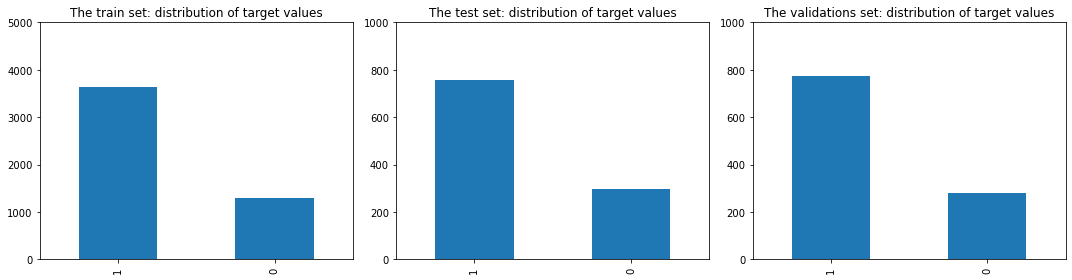

In [22]:
# check distribution of target on train/test/validation data
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

ax = axs[0]
dft = y_train.value_counts()
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of target values')

ax = axs[1]
dft = y_test.value_counts()
dft.plot.bar(ax=ax)
ax.set_ylim([0, 1000])
ax.set_title('The test set: distribution of target values')

ax = axs[2]
dft = y_valid.value_counts()
dft.plot.bar(ax=ax)
ax.set_ylim([0, 1000])
ax.set_title('The validations set: distribution of target values')

fig.tight_layout()

There is a similar distribution and imbalance seen in both the train and test target values. If our best models cannot achieve the desired accuracy we could attempt upsampling.

### 2.2 Model Training &  Evaluation <a class="anchor" id="2_2"></a>

We will evaluate each model based on its AUC-ROC and accuracy with the validation data.

In [62]:
def evaluate_model(model, features, target, neural=False, graph=True,SET='validation'):
    
    eval_stats = {}

    if neural == False:
        pred_proba_ = model.predict_proba(features)[:, 1]
        pred_target = model.predict(features)
    else:
        pred_proba_ = model.predict(features)
        pred_target = np.where(model.predict(features)[:,0] >= 0.5,1,0)

    # ROC/Accuracy
    fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba_)
    roc_auc = metrics.roc_auc_score(target, pred_proba_)
    
    eval_stats['ROC AUC'] = roc_auc
    eval_stats['Accuracy'] = metrics.accuracy_score(target, pred_target)
    
    if graph == True:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        ax.plot(fpr, tpr, color='blue', label='{:} ROC AUC={:.2f}'.format(SET, roc_auc))
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title('ROC Curve of {:} data'.format(SET))
    
    print(eval_stats)
    return

#### 2.2.1 Dummy Model <a class="anchor" id="2_2_1"></a>

{'ROC AUC': 0.5, 'Accuracy': 0.7345971563981043}


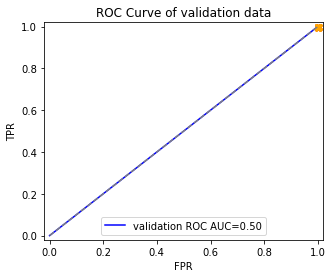

In [30]:
# dummy model
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train,y_train)
evaluate_model(dummy_model,X_valid,y_valid)

#### 2.2.2 Logistic Regressor <a class="anchor" id="2_2_2"></a>

{'ROC AUC': 0.8395023041474654, 'Accuracy': 0.7990521327014218}


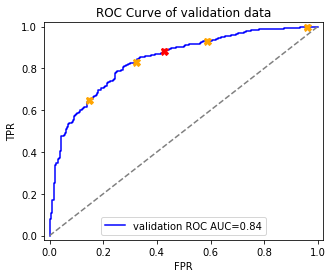

In [31]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
evaluate_model(lr_model,X_valid,y_valid)

#### 2.2.3 Boosted Classifier - CatBoost <a class="anchor" id="2_2_3"></a>

Learning rate set to 0.046975
0:	learn: 0.6589823	test: 0.6592038	best: 0.6592038 (0)	total: 13.6ms	remaining: 13.6s
200:	learn: 0.2762899	test: 0.3290262	best: 0.3290262 (200)	total: 502ms	remaining: 2s
400:	learn: 0.2059892	test: 0.2928713	best: 0.2928713 (400)	total: 1.07s	remaining: 1.6s
600:	learn: 0.1616437	test: 0.2824087	best: 0.2822069 (599)	total: 1.91s	remaining: 1.27s
800:	learn: 0.1308795	test: 0.2789008	best: 0.2787868 (799)	total: 2.54s	remaining: 631ms
999:	learn: 0.1086600	test: 0.2770382	best: 0.2766250 (922)	total: 3.08s	remaining: 0us

bestTest = 0.2766249579
bestIteration = 922

Shrink model to first 923 iterations.
{'ROC AUC': 0.9260829493087557, 'Accuracy': 0.8872037914691943}


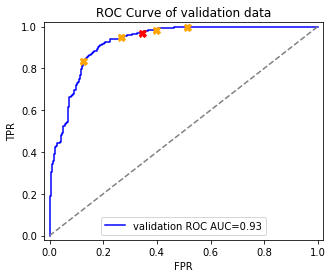

In [32]:
# boosted classifier - catboost
cb_model = CatBoostClassifier(verbose=200, random_seed=12345)
cb_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

evaluate_model(cb_model,X_valid,y_valid)

#### 2.2.4 Multilayer Neural Network <a class="anchor" id="2_2_4"></a>

In [48]:
# multilayer neural network - fitting
nn_model = Sequential()

nn_model.add(Dense(30, input_dim=(X_train.shape[1]), activation='sigmoid'))
nn_model.add(Dense(10, activation='sigmoid'))
nn_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=0.04)

nn_model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer, 
    metrics=['AUC','acc']
)

nn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 30)                810       
                                                                 
 dense_13 (Dense)            (None, 10)                310       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,131
Trainable params: 1,131
Non-trainable params: 0
_________________________________________________________________



Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
{'ROC AUC': 0.8583963133640553, 'Accuracy': 0.8123222748815165}


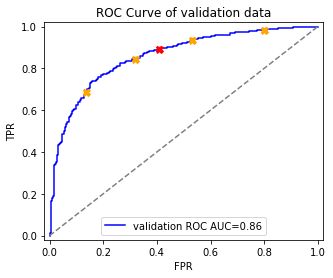

In [63]:
# cnn - training and evaluation
earlystop = EarlyStopping(patience=2)
     
# learning rate will adjust during training
learning_rate_reduction = ReduceLROnPlateau(monitor='auc', 
                                        patience=2, 
                                        verbose=1, 
                                        factor=0.5, 
                                        min_lr=0.00001)
        
nn_model.fit(X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=30,
    batch_size=32,
    verbose=0,
    callbacks=[earlystop, learning_rate_reduction]
) 

evaluate_model(nn_model,X_valid,y_valid,neural=True)

Based on the ROC-AUC value of the validation data I will use the CatBoost classifier and tune parameters.

### 3 Parameter Hypertuning <a class="anchor" id="3"></a>

In [35]:
%%time
## hypertune model parameters with cross-validation
cf = CatBoostClassifier(silent=True,random_seed=12345)
params = {
    'depth':[1,2,3,4,5,6],
    'learning_rate': [0.01,0.02,0.03,0.04],
    'iterations': [50,100,150],
    'l2_leaf_reg': [1,2,3,4],
    'border_count': [50,100,150,200]   
}

Grid_CBC = GridSearchCV(estimator=cf, scoring='roc_auc', param_grid=params,cv=3,verbose=10)
Grid_CBC.fit(X_train, y_train,eval_set=(X_test, y_test))

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits
[CV 1/3; 1/1152] START border_count=50, depth=1, iterations=50, l2_leaf_reg=1, learning_rate=0.01
[CV 1/3; 1/1152] END border_count=50, depth=1, iterations=50, l2_leaf_reg=1, learning_rate=0.01;, score=0.801 total time=   0.0s
[CV 2/3; 1/1152] START border_count=50, depth=1, iterations=50, l2_leaf_reg=1, learning_rate=0.01
[CV 2/3; 1/1152] END border_count=50, depth=1, iterations=50, l2_leaf_reg=1, learning_rate=0.01;, score=0.811 total time=   0.0s
[CV 3/3; 1/1152] START border_count=50, depth=1, iterations=50, l2_leaf_reg=1, learning_rate=0.01
[CV 3/3; 1/1152] END border_count=50, depth=1, iterations=50, l2_leaf_reg=1, learning_rate=0.01;, score=0.826 total time=   0.0s
[CV 1/3; 2/1152] START border_count=50, depth=1, iterations=50, l2_leaf_reg=1, learning_rate=0.02
[CV 1/3; 2/1152] END border_count=50, depth=1, iterations=50, l2_leaf_reg=1, learning_rate=0.02;, score=0.807 total time=   0.0s
[CV 2/3; 2/1152] START bord

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001E0C9D710A0>,
             param_grid={'border_count': [50, 100, 150, 200],
                         'depth': [1, 2, 3, 4, 5, 6],
                         'iterations': [50, 100, 150],
                         'l2_leaf_reg': [1, 2, 3, 4],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]},
             scoring='roc_auc', verbose=10)

In [36]:
print("\n Best ROC-AUC:",Grid_CBC.best_score_.round(4))
print(Grid_CBC.best_params_)


 Best ROC-AUC: 0.8918
{'border_count': 100, 'depth': 6, 'iterations': 150, 'l2_leaf_reg': 2, 'learning_rate': 0.04}


#### Untuned Model

{'ROC AUC': 0.9335572079635405, 'Accuracy': 0.8862559241706162}


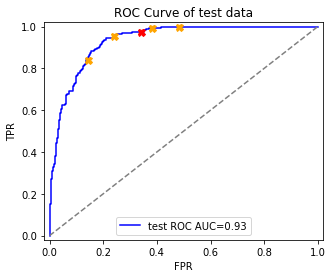

In [37]:
# train, fit, and evaluate model on test data
cb = CatBoostClassifier(silent=True,random_seed=12345)
cb.fit(X_train, y_train, eval_set=(X_test, y_test))
evaluate_model(cb,X_test,y_test,SET='test')

#### Tuned Model

{'ROC AUC': 0.89978500928369, 'Accuracy': 0.8606635071090047}


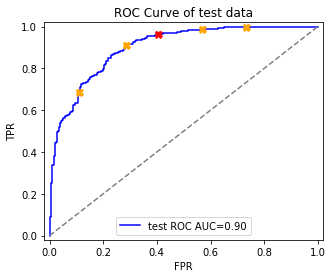

In [38]:
# train, fit, and evaluate model on test data
cb_tuned = CatBoostClassifier(
    border_count=100,
    depth=6,
    iterations=150,
    l2_leaf_reg=2,
    learning_rate=0.04,
    verbose=False,
    random_seed=12345
)
cb_tuned.fit(X_train, y_train, eval_set=(X_test, y_test))
evaluate_model(cb_tuned,X_test,y_test,SET='test')

The untuned model achieves a better ROC AUC value of 0.93

## Conclusion <a class="anchor" id="end"></a>

All of the steps outlined in my initial plan were followed. There were some things that I hadn't planned on doing such as:
- splitting the data further to have a validation set in the model decision process
- hypertuning by way of gridsearch

I had difficulties in setting up the multilayer neural network for training but my evaluator quickly pointed out the simple syntax mistake I was making. It took a few iterations of fixing small issues and bias to get the proper model and accuracy. I also did a peer review do help find issues.

The key steps to solving the task were:
- logically organize and format the data into meaningful features/target
- split data into train. test, and validation sets
- train data with multiple model types
- iterate

The final model I chose was the CatBoost Classifier because it performed the best with the validation data set. Its AUC-ROC score is 0.935 (it performed better untuned).